<a href="https://colab.research.google.com/github/officialbrowncoffee/officialbrowncoffee/blob/main/Factorization_Machine_based_Neural_network_for_ctr_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Link to Reference Paper](https://www.ijcai.org/proceedings/2017/0239.pdf)


[Avazu Dataset](https://www.kaggle.com/c/avazu-ctr-prediction)

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import gc

plt.style.use('ggplot')

import warnings as w
w.filterwarnings(action='ignore')
pd.set_option('display.max_columns', None)

In [2]:
dtype = {
    'id': np.dtype(int),
    'click': np.dtype(int),
    'hour' : str,
    'C1': np.dtype(str),
    'banner_pos': np.dtype(str),
    'site_id': np.dtype(str),
    'site_domain': np.dtype(str),
    'site_category': np.dtype(str),
    'app_id': np.dtype(str),
    'app_domain': np.dtype(str),
    'app_category': np.dtype(str),
    'device_id': np.dtype(str),
    'device_ip': np.dtype(str),
    'device_model': np.dtype(str),
    'device_type': np.dtype(str),
    'device_conn_type': np.dtype(str),
    'C14': np.dtype(str),
    'C15': np.dtype(str),
    'C16': np.dtype(str),
    'C17': np.dtype(str),
    'C18': np.dtype(str),
    'C19': np.dtype(str),
    'C20': np.dtype(str),
    'C21': np.dtype(str)
}
num_records = 40428967
sample_size = 5000000
skip_values = sorted(random.sample(range(1,num_records), num_records - sample_size))
parse_date = lambda val : pd.to_datetime(val, format='%y%m%d%H')



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Load the training dataset
train = pd.read_csv("/content/drive/MyDrive/Avazu_dataset/avazu-ctr-prediction/train.gz",
                    parse_dates=['hour'],  # Parse the 'hour' column as dates
                    date_parser=parse_date,  # Use the provided parse_date function to parse dates
                    dtype=dtype,  # Specify data types for columns
                    skiprows=skip_values)  # Skip rows as per the skip_values list

# Load the test dataset
test = pd.read_csv('/content/drive/MyDrive/Avazu_dataset/avazu-ctr-prediction/test.gz')

# Load the submission dataset (presumably containing sample submissions)
submission = pd.read_csv('/content/drive/MyDrive/Avazu_dataset/avazu-ctr-prediction/sampleSubmission.gz')

# Print the shape of each dataset
print('Train dataset:', train.shape)
print('Test dataset:', test.shape)
print('Submission:', submission.shape)


Train dataset: (5000000, 24)
Test dataset: (4577464, 23)
Submission: (4577464, 2)


In [5]:
train.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1000009418151094273,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,ddd2926e,44956a24,1,2,15706,320,50,1722,0,35,-1,79
1,10000169349117863715,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,96809ac8,711ee120,1,0,15704,320,50,1722,0,35,100084,79
2,10002028568167339219,0,2014-10-21,1005,0,9e8cf15d,0d3cb7be,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,58811cdf,8326c04b,1,2,20596,320,50,2161,0,35,100148,157
3,10003585669470236873,0,2014-10-21,1005,0,d9750ee7,98572c79,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,9b1fe278,128f4ba1,1,0,17914,320,50,2043,2,39,-1,32
4,10011650513707909570,0,2014-10-21,1005,0,85f751fd,c4e18dd6,50e219e0,febd1138,82e27996,0f2161f8,a99f214a,1ce4451d,99e427c9,1,0,21611,320,50,2480,3,297,100111,61


In [6]:
test.head()

,id,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1.000017e+19,14103100,1005,0,235ba823,f6ebf28e,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,69f45779,0eb711ec,1,0,8330,320,50,761,3,175,100075,23
1,1.000018e+19,14103100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,e8d44657,ecb851b2,1,0,22676,320,50,2616,0,35,100083,51
2,1.000055e+19,14103100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,10fb085b,1f0bc64f,1,0,22676,320,50,2616,0,35,100083,51
3,1.000109e+19,14103100,1005,0,85f751fd,c4e18dd6,50e219e0,51cedd4e,aefc06bd,0f2161f8,a99f214a,422d257a,542422a7,1,0,18648,320,50,1092,3,809,100156,61
4,1.000138e+19,14103100,1005,0,85f751fd,c4e18dd6,50e219e0,9c13b419,2347f47a,f95efa07,a99f214a,078c6b38,1f0bc64f,1,0,23160,320,50,2667,0,47,-1,221


In [7]:
# Check for missing values in the train DataFrame and summarize the results
train.isna().sum()

id                  0
click               0
hour                0
C1                  0
banner_pos          0
site_id             0
site_domain         0
site_category       0
app_id              0
app_domain          0
app_category        0
device_id           0
device_ip           0
device_model        0
device_type         0
device_conn_type    0
C14                 0
C15                 0
C16                 0
C17                 0
C18                 0
C19                 0
C20                 0
C21                 0
dtype: int64

click
0    4150700
1     849300
Name: count, dtype: int64


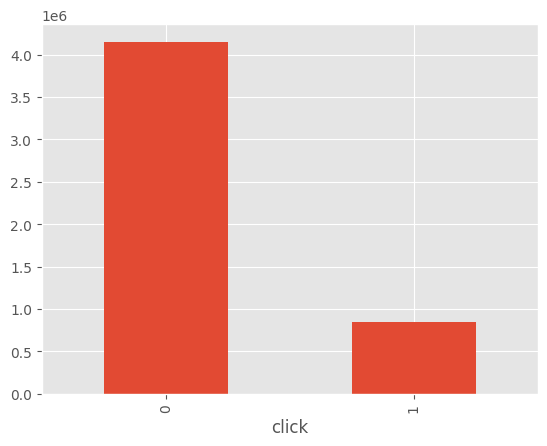

In [8]:
# Visualize the distribution of click values in the train DataFrame with a bar plot
train.click.value_counts().plot(kind='bar')

# Print the count of each unique click value
print(train.click.value_counts())


**Target Feature data Imbalance**

In [9]:
# Count the occurrences of each unique value in the "banner_pos" column of the train DataFrame
banner_pos_counts = train['banner_pos'].value_counts()
banner_pos_counts.name = 'banner_pos'
print(banner_pos_counts)


banner_pos
0    3601143
1    1389877
7       5432
2       1575
4       1004
5        715
3        254
Name: banner_pos, dtype: int64


<Axes: xlabel='banner_pos', ylabel='count'>

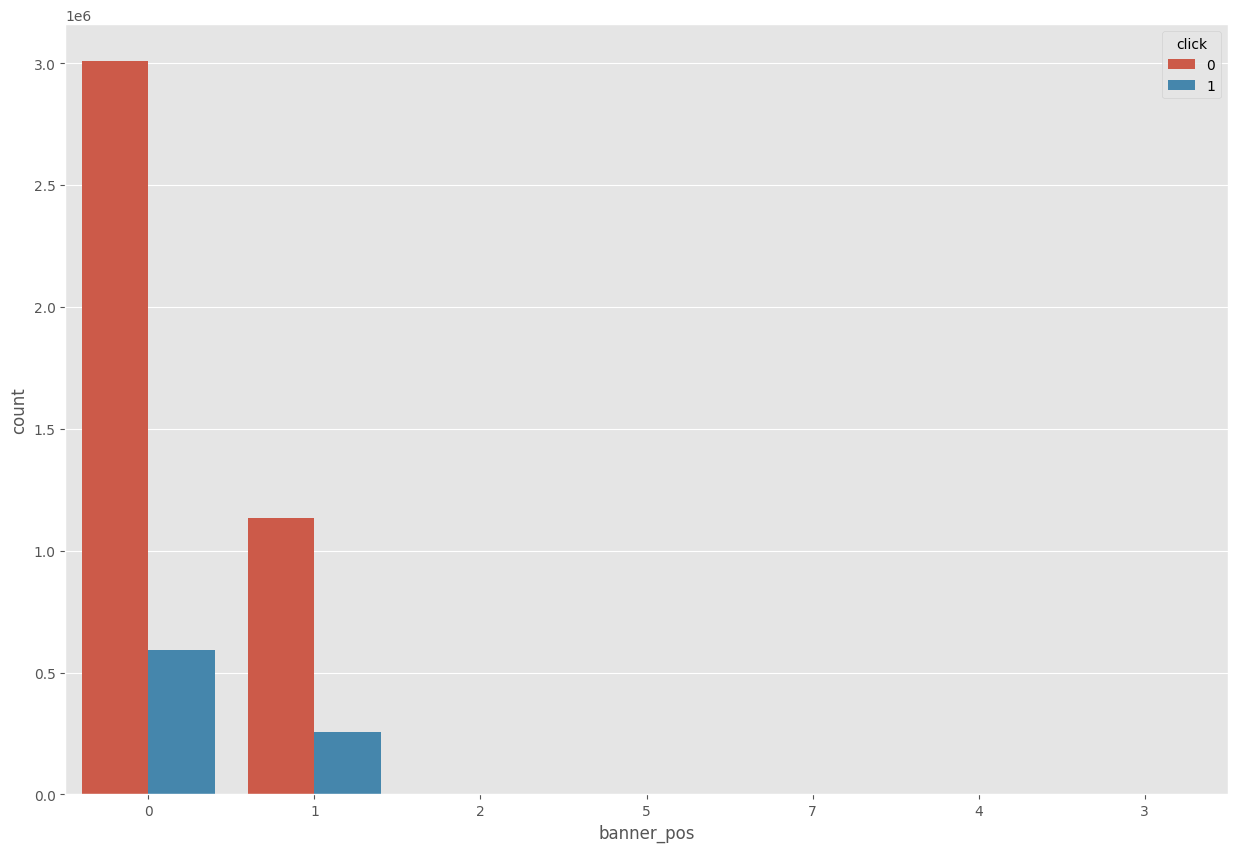

In [10]:
plt.figure(figsize=(15,10))
sns.countplot(x='banner_pos', hue='click', data=train)

The code creates a count plot using seaborn to visualize the distribution of click values across different hours in the train dataframe.

<Axes: xlabel='hour', ylabel='count'>

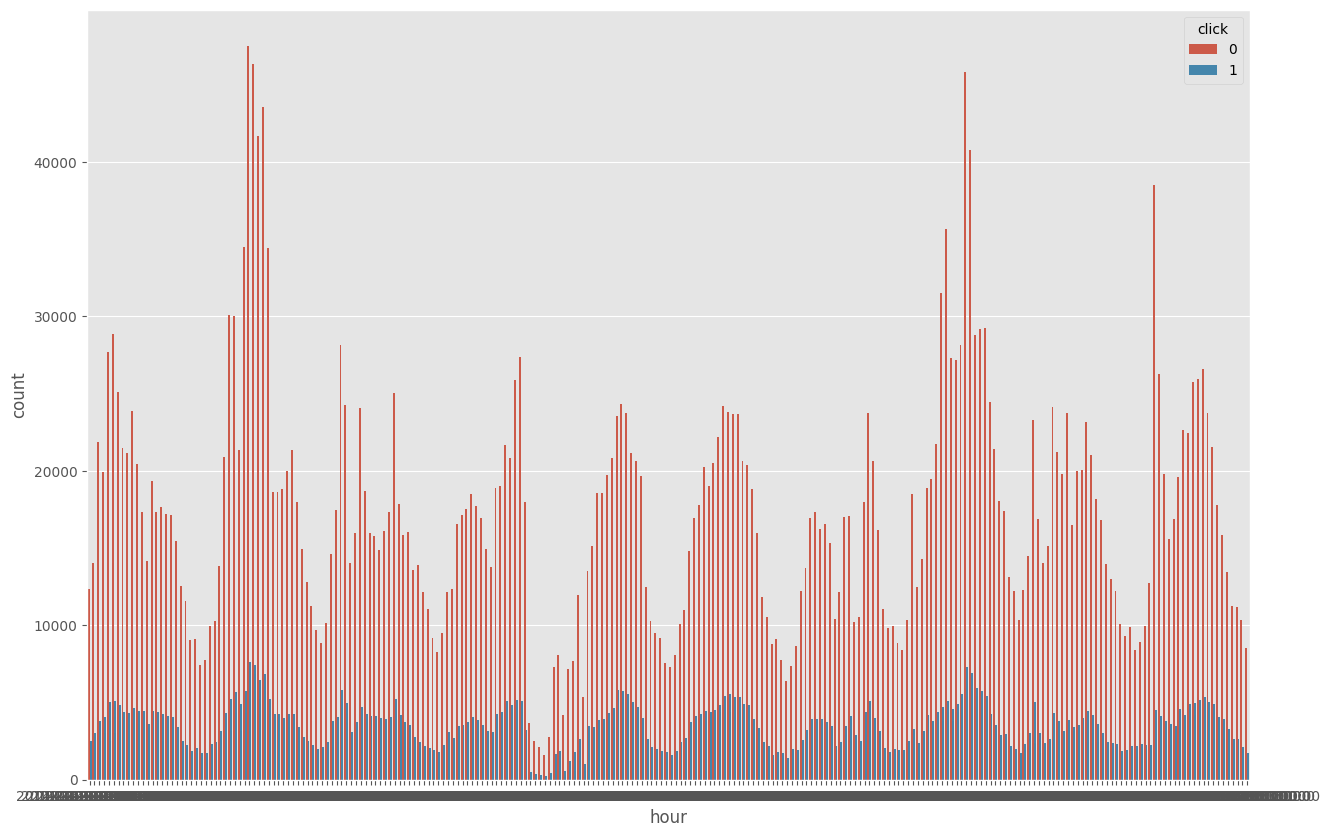

In [11]:
#Set the figure size for the plot
plt.figure(figsize=(15, 10))

#Create a count plot using seaborn to visualize click distribution across hours
sns.countplot(x='hour', hue='click', data=train)


The date is too long to identify characteristics, so sample data is taken to run a sample survey. The code filters the "train" DataFrame to include only rows where the hour is before '2014-10-22'.

In [12]:
#Create a new DataFrame ex_data containing rows where the hour is less than '2014-10-22'
ex_data = train[train.hour < '2014-10-22']

#Display the first few rows of the ex_data DataFrame
ex_data.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1000009418151094273,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,ddd2926e,44956a24,1,2,15706,320,50,1722,0,35,-1,79
1,10000169349117863715,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,96809ac8,711ee120,1,0,15704,320,50,1722,0,35,100084,79
2,10002028568167339219,0,2014-10-21,1005,0,9e8cf15d,0d3cb7be,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,58811cdf,8326c04b,1,2,20596,320,50,2161,0,35,100148,157
3,10003585669470236873,0,2014-10-21,1005,0,d9750ee7,98572c79,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,9b1fe278,128f4ba1,1,0,17914,320,50,2043,2,39,-1,32
4,10011650513707909570,0,2014-10-21,1005,0,85f751fd,c4e18dd6,50e219e0,febd1138,82e27996,0f2161f8,a99f214a,1ce4451d,99e427c9,1,0,21611,320,50,2480,3,297,100111,61


<Axes: xlabel='hour', ylabel='count'>

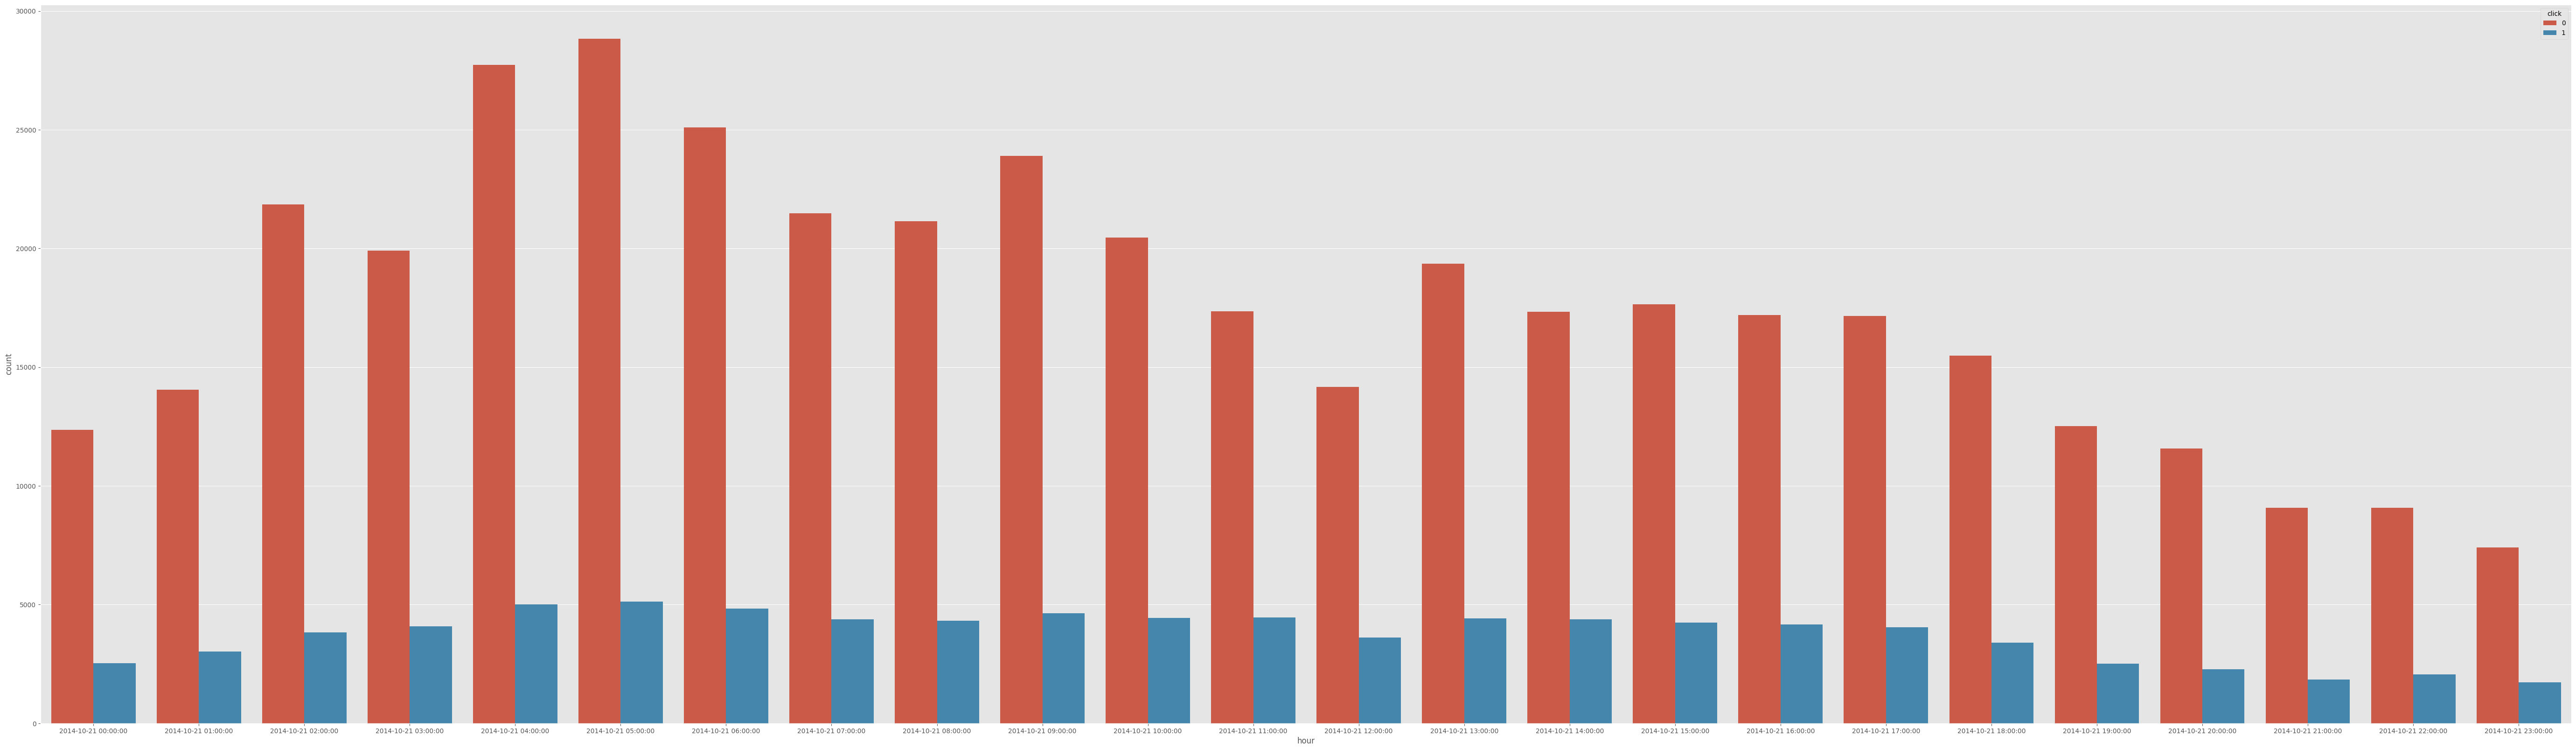

In [13]:
#Set the figure size for the plot
plt.figure(figsize=(70, 20))

#create a count plot using seaborn to visualize click distribution across hours in ex_data
sns.countplot(x='hour', hue='click', data=ex_data)

Clicks doesnt appear to significantly be affected by time.

In [14]:
del ex_data #Delete the ex_data DataFrame to free up memory
gc.collect() #Trigger garbage collection to free up unused memory

4370

This code sets the index of the 'train' DataFrame to the 'hour' column. The 'inplace=True' parameter ensures that the operation is performed on the DataFrame itself

In [15]:
train.set_index('hour', inplace=True)

Setting the index of the 'test' DataFrame to the 'hour' column means that the 'hour' column will become the index of the DataFrame instead of the default integer index. The code is mostly used to facilitate time-based operations and analysis, especially when dealing with time series data.

In [16]:
test.set_index('hour', inplace=True)

In [17]:
train.head()

,id,click,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
hour,,,,,,,,,,,,,,,,,,,,,,,
2014-10-21,1000009418151094273,0,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,ddd2926e,44956a24,1,2,15706,320,50,1722,0,35,-1,79
2014-10-21,10000169349117863715,0,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,96809ac8,711ee120,1,0,15704,320,50,1722,0,35,100084,79
2014-10-21,10002028568167339219,0,1005,0,9e8cf15d,0d3cb7be,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,58811cdf,8326c04b,1,2,20596,320,50,2161,0,35,100148,157
2014-10-21,10003585669470236873,0,1005,0,d9750ee7,98572c79,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,9b1fe278,128f4ba1,1,0,17914,320,50,2043,2,39,-1,32
2014-10-21,10011650513707909570,0,1005,0,85f751fd,c4e18dd6,50e219e0,febd1138,82e27996,0f2161f8,a99f214a,1ce4451d,99e427c9,1,0,21611,320,50,2480,3,297,100111,61


**Sparse Feature**


*   C1
*   banner_pos
*   site_id
*   site_domain
*   site_category
*   app_id
*   app_domain
*   app_category
*   device_id
*   device_ip
*   device_model
*   device_type
*   device_conn_type

**Dense Features**

*   C14 ¬ C21

*Sparse features typically have a low frequency of occurence or a large number of unique values, while dense features tend to have a higher frequency of occurrence or a smaller number of unique values*






In [18]:
!pip install torch --upgrade

In [19]:
!pip install deepctr --upgrade

  Using cached deepctr-0.9.3-py3-none-any.whl (141 kB)
  Using cached h5py-3.7.0-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (4.5 MB)
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0


In [20]:
from deep

SyntaxError: invalid syntax (<ipython-input-20-706292abab93>, line 1)

In [21]:
#Import the PyTorch library
import torch

#Import classess and functions from deepctr_torch.inputs module
from deepctr_torch.inputs import SparseFeat, DenseFeat, get_feature_names

#Import all models from deepctr_torch.models module
from deepctr_torch.models import *

In [23]:
# Import the PyTorch library
import torch

# Import classes and functions from deepctr_torch.inputs module
from deepctr_torch.inputs import SparseFeat, DenseFeat, get_feature_names

# Import all models from deepctr_torch.models module
from deepctr_torch.models import DeepFM

In [24]:
data = train

In [25]:
#Get the column names of sparse features from columns (2 to 14) and convert them to a list
sparse_features = train.iloc[:, 2:14].columns.values.tolist()

#Get the column names of dense features from column 15 to the end and convert them to a list
dense_features = train.iloc[:, 15:].columns.values.tolist()

#Append the'id' column name to the list of sparse features
sparse_features.append('id')

#Define the target variable as 'click'
target = ['click']

In [26]:
test.head()

,id,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
hour,,,,,,,,,,,,,,,,,,,,,,
14103100,1.000017e+19,1005,0,235ba823,f6ebf28e,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,69f45779,0eb711ec,1,0,8330,320,50,761,3,175,100075,23
14103100,1.000018e+19,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,e8d44657,ecb851b2,1,0,22676,320,50,2616,0,35,100083,51
14103100,1.000055e+19,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,10fb085b,1f0bc64f,1,0,22676,320,50,2616,0,35,100083,51
14103100,1.000109e+19,1005,0,85f751fd,c4e18dd6,50e219e0,51cedd4e,aefc06bd,0f2161f8,a99f214a,422d257a,542422a7,1,0,18648,320,50,1092,3,809,100156,61
14103100,1.000138e+19,1005,0,85f751fd,c4e18dd6,50e219e0,9c13b419,2347f47a,f95efa07,a99f214a,078c6b38,1f0bc64f,1,0,23160,320,50,2667,0,47,-1,221


In [27]:
#Get the column names of sparse features from columns 0 to 14 (excluding 14) in the test DataFrame and convert them to a list
test_sparse_features = test.iloc[:, 0:14].columns.values.tolist()

#Get the column names of dense features from column14 to the end of the DataFrame in the test DataFrame and convert them to a list
test_dense_features = test.iloc[:, 14:].columns.values.tolist()

In [28]:
# Importing MinMaxScaler and LabelEncoder classes from sklearn.preprocessing module
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Creating an instance of MinMaxScaler with feature range between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))

#Creating an instance of LabelEncoder for encoding categorical labels into numerical values
encoder = LabelEncoder()


In [29]:
#Iterate over each sparse feature in the list of sparse features
for feat in sparse_features:
  #Apply label encoding to the current sparse feature using the encoder and replace the original values with encoded values
  data[feat] = encoder.fit_transform(data[feat])

#Transform the dense features using the MinMaxScaler
data[dense_features] = scaler.fit_transform(data[dense_features])

In [30]:
#Iterate over each sparse features in the list of sparse features for the test dataset
for feat in test_sparse_features:

    #Apply label encoding to the current sparse feature using the encoder and replace the original values with encoded values
    test[feat] = encoder.fit_transform(test[feat])

#Transform the dense features using the MinMaxScaler for the test dataset
test[dense_features] = scaler.fit_transform(test[test_dense_features])

In [31]:
#Create SparseFeat feature columns for sparse features and DenseFeat feature columns for dense features
fixlen_feature_columns = [
    SparseFeat(feat, data[feat].nunique()) for feat in sparse_features
] + [
    DenseFeat(feat, 1) for feat in dense_features
]

In [32]:
#fixlen_feature_columns = [SparseFeat(feat, data[feat].nunique())
#                          for feat in sparse_features] + [DenseFeat(feat, 1)
#                                                          for feat in dense_features]

The code dispalys the contents of the 'fixlen_feature_columns' variable which will be a list of feature columns using 'SparseFeat' and 'DenseFeat'.

In [33]:
fixlen_feature_columns

[SparseFeat(name='C1', vocabulary_size=7, embedding_dim=4, use_hash=False, dtype='int32', embedding_name='C1', group_name='default_group'),
 SparseFeat(name='banner_pos', vocabulary_size=7, embedding_dim=4, use_hash=False, dtype='int32', embedding_name='banner_pos', group_name='default_group'),
 SparseFeat(name='site_id', vocabulary_size=3515, embedding_dim=4, use_hash=False, dtype='int32', embedding_name='site_id', group_name='default_group'),
 SparseFeat(name='site_domain', vocabulary_size=4514, embedding_dim=4, use_hash=False, dtype='int32', embedding_name='site_domain', group_name='default_group'),
 SparseFeat(name='site_category', vocabulary_size=23, embedding_dim=4, use_hash=False, dtype='int32', embedding_name='site_category', group_name='default_group'),
 SparseFeat(name='app_id', vocabulary_size=5214, embedding_dim=4, use_hash=False, dtype='int32', embedding_name='app_id', group_name='default_group'),
 SparseFeat(name='app_domain', vocabulary_size=333, embedding_dim=4, use_has

In [35]:
#Assigning the list of feature columns to the variable dnn_feature_colums
dnn_feature_columns = fixlen_feature_columns

#Assigning the same list of feature columns to the variable linear_feature_columns
linear_feature_columns = fixlen_feature_columns

In [36]:
#Combine linear_feature_columns and dnn_feature_columns to create a list of all feature columns
all_feature_columns = linear_feature_columns + dnn_feature_columns

#Use the get_feature_names function to extract the names of features from the list of feature columns
feature_names = get_feature_names(all_feature_columns)

#Display the feature names
feature_names

['C1',
 'banner_pos',
 'site_id',
 'site_domain',
 'site_category',
 'app_id',
 'app_domain',
 'app_category',
 'device_id',
 'device_ip',
 'device_model',
 'device_type',
 'id',
 'C14',
 'C15',
 'C16',
 'C17',
 'C18',
 'C19',
 'C20',
 'C21']

The code is typically used to train machile learning models, where each features is passed as input to the model during training

In [37]:
#Create a dictionary where the keys are features names and the values are the corresponding feature data
train_model_input = {name: data[name] for name in feature_names}

In [38]:
#Create a dictionary where the keys are feature names and the values are the corresponding feature data from the test DataFrame
test_model_input = {name: test[name] for name in feature_names}

In [39]:
#Check if CUDA-enabled GPU is available: if yes, set device to 'cuda', otherwise set it to 'cpu'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

**DEEP_FM MODEL**

The DeepFM model was initialized using the 'DeepFM' class from the 'deepctr_torch,models' module. The model is configured with feature columns for both the linear and DNN parts, specifying the task as binary classification. Dropout regularization with a dropout rate of 0.7 was applied to the DNN part of the model

In [40]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available!")
else:
    print("CUDA is not available.")


CUDA is available!


In [41]:
# Get information about GPU device(s)
if torch.cuda.is_available():
    device = torch.cuda.current_device()
    properties = torch.cuda.get_device_properties(device)
    print("GPU Name:", properties.name)
    print("GPU Capability:", properties.major, properties.minor)
    print("Memory Total (GB):", properties.total_memory / 1024**3)


GPU Name: Tesla T4
GPU Capability: 7 5
Memory Total (GB): 14.74810791015625


In [42]:
model = DeepFM(linear_feature_columns, dnn_feature_columns,
               task='binary', device=device, dnn_dropout=0.7)
model

DeepFM(
  (embedding_dict): ModuleDict(
    (C1): Embedding(7, 4)
    (banner_pos): Embedding(7, 4)
    (site_id): Embedding(3515, 4)
    (site_domain): Embedding(4514, 4)
    (site_category): Embedding(23, 4)
    (app_id): Embedding(5214, 4)
    (app_domain): Embedding(333, 4)
    (app_category): Embedding(30, 4)
    (device_id): Embedding(598549, 4)
    (device_ip): Embedding(1905317, 4)
    (device_model): Embedding(6507, 4)
    (device_type): Embedding(5, 4)
    (id): Embedding(5000000, 4)
  )
  (linear_model): Linear(
    (embedding_dict): ModuleDict(
      (C1): Embedding(7, 1)
      (banner_pos): Embedding(7, 1)
      (site_id): Embedding(3515, 1)
      (site_domain): Embedding(4514, 1)
      (site_category): Embedding(23, 1)
      (app_id): Embedding(5214, 1)
      (app_domain): Embedding(333, 1)
      (app_category): Embedding(30, 1)
      (device_id): Embedding(598549, 1)
      (device_ip): Embedding(1905317, 1)
      (device_model): Embedding(6507, 1)
      (device_type): Em

In [43]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


Model is compiled using the compile method. The Adam optimizer was chosen with binary-cross entropynloss for binary classification tasks. Evaluation metrics were set to include both binary cross-entropy and AUC(Area Under the ROC Curve)

In [44]:
#Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['binary_crossentropy', 'auc'])

In [ ]:
%%time
history = model.fit(train_model_input, train[target].values, batch_size=1024, epochs=10, verbose=1,
                    validation_split=0.2)

0
Train on 4000000 samples, validate on 1000000 samples, 3907 steps per epoch


3907it [02:38, 24.63it/s]


Epoch 1/10
165s - loss:  0.4055 - binary_crossentropy:  0.4054 - auc:  0.7361 - val_binary_crossentropy:  0.3924 - val_auc:  0.7397


3907it [02:37, 24.80it/s]


Epoch 2/10
165s - loss:  0.0175 - binary_crossentropy:  0.0172 - auc:  0.9973 - val_binary_crossentropy:  0.4603 - val_auc:  0.6981


3907it [02:37, 24.85it/s]


Epoch 3/10
164s - loss:  0.0005 - binary_crossentropy:  0.0002 - auc:  1.0000 - val_binary_crossentropy:  0.7009 - val_auc:  0.6948


3907it [02:37, 24.85it/s]


Epoch 4/10
164s - loss:  0.0203 - binary_crossentropy:  0.0202 - auc:  0.9987 - val_binary_crossentropy:  0.4853 - val_auc:  0.7209


3907it [02:37, 24.84it/s]


Epoch 5/10
164s - loss:  0.1133 - binary_crossentropy:  0.1131 - auc:  0.9778 - val_binary_crossentropy:  0.4537 - val_auc:  0.6986


3907it [02:36, 24.94it/s]


Epoch 6/10
163s - loss:  0.0813 - binary_crossentropy:  0.0810 - auc:  0.9915 - val_binary_crossentropy:  0.4231 - val_auc:  0.7147


3907it [02:36, 24.97it/s]


Epoch 7/10
163s - loss:  0.0286 - binary_crossentropy:  0.0283 - auc:  0.9986 - val_binary_crossentropy:  0.5103 - val_auc:  0.7171


201it [00:08, 27.56it/s]

In [ ]:
# Assuming 'model' is your trained model and 'test_model_input' is your test data

# Make predictions on the test data
predictions = model.predict(test_model_input)

# Print or use the predictions
print(predictions)


In [46]:
pred_ans = model.predict(test_model_input, 1024)

In [47]:
submission['click'] = pred_ans

In [48]:
submission

,id,click
0,10000174058809263569,0.000000
1,10000182526920855428,0.000000
2,10000554139829213984,0.000000
3,10001094637809798845,0.000000
4,10001377041558670745,1.000000
...,...,...
4577459,9998166651591969718,0.156244
4577460,9998249812366450951,0.000000
4577461,99988023653614546,0.000029
4577462,9999086574712596585,0.000000


from matplotlib import pyplot as plt
submission['id'].plot(kind='hist', bins=20, title='id')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
submission['click'].plot(kind='hist', bins=20, title='click')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
submission.plot(kind='scatter', x='id', y='click', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
submission['id'].plot(kind='line', figsize=(8, 4), title='id')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
submission['click'].plot(kind='line', figsize=(8, 4), title='click')
plt.gca().spines[['top', 'right']].set_visible(False)

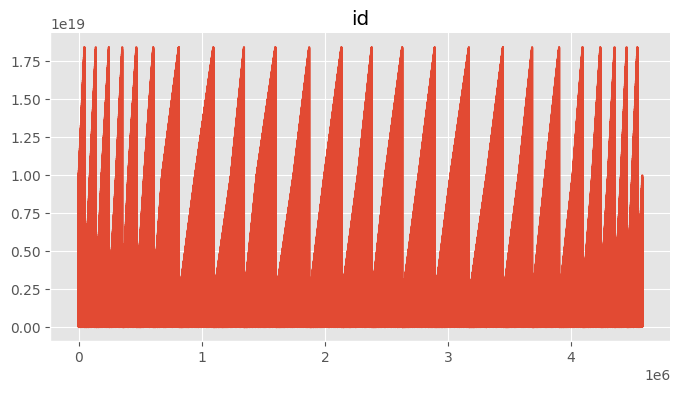

In [50]:
from matplotlib import pyplot as plt
submission['id'].plot(kind='line', figsize=(8, 4), title='id')
plt.gca().spines[['top', 'right']].set_visible(False)

In [49]:
submission.to_csv('submission.csv', index=False)